**Import Library**


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
from albumentations.pytorch import ToTensorV2



In [ ]:
!nvidia-smi

Wed Feb  1 05:39:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**MENGHUBUNGKAN KE GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**MENGAKTIFKAN SAVE MODEL**

In [ ]:
CHECKPOINT_FILE = "1152KaggleBest.pth.tar"
PIN_MEMORY = True
SAVE_MODEL = True

**MEMBUAT FUNGSI AUGMENTASI**

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

**MEMBUAT FUNGSI UNTUK MENGGABUNGKAN ANNOTASI BOX DAN GAMBAR**

In [ ]:
class PestDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]

            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

**MEMANGGIL DATASET UNTUK TRAINING**

In [ ]:
#Memanggil dataset
dataset_path = "/content/drive/MyDrive/Dataset/"

**MEMANGGIL DATA TRAIN DAN VALIDASI**

In [ ]:
#  DATA TRAIN
train_dataset = PestDetection(root=dataset_path, transforms=get_transforms(True))

In [ ]:
# DATA VALIDASI
test_dataset = PestDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
# memanggil file annotation untuk membuat box di data train 
coco = COCO(os.path.join(dataset_path, 'train/','_annotations.coco.json'))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=4.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'Pest', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Belalang', 'supercategory': 'Pest'},
 2: {'id': 2, 'name': 'Sehat', 'supercategory': 'Pest'},
 3: {'id': 3, 'name': 'Ulat', 'supercategory': 'Pest'},
 4: {'id': 4, 'name': 'Wereng', 'supercategory': 'Pest'}}

In [ ]:
#  MEMANGGIL LABEL
classes = [i[1]['name'] for i in categories.items()]
classes

['Pest', 'Belalang', 'Sehat', 'Ulat', 'Wereng']

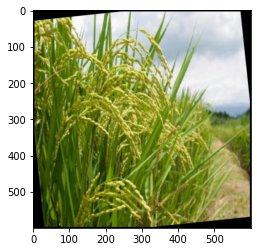

In [ ]:
# contoh data train yang sudah dikasih box
sample = train_dataset[8]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

**`MEMANGGIL TRUE LABEL `**

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Ta/Dataset/valid/_classes.csv', sep=',')



In [ ]:
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

In [ ]:
test_labels = labels.apply(get_label, axis=1)

**MEMANGGIL MODEL FASTER RCNN DARI LIBRARY**

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

**`MEMBUAT FUNGSI SAVE MODEL `**

In [ ]:
def save_checkpoint(state, filename="faster_rcnn.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

**MEMBUAT FUNGSI TRAIN**

In [ ]:
best_loss = np.inf

def train_one_epoch(model, optimizer, loader, device, epoch):
    global best_loss
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    for images, targets in tqdm(loader):
      
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
          
          loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
          
          all_losses.append(loss_value)
          all_losses_dict.append(loss_dict_append)
          
          if not math.isfinite(loss_value):
              print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
              print(loss_dict)
              sys.exit(1)
          
          
          losses.backward()
          
        

    
    if np.mean(all_losses) < best_loss:
      best_loss = np.mean(all_losses)
      if SAVE_MODEL:
            print("Model improved, saving...")
            checkpoint = {
                "state_dict": model.state_dict(),
                
            }
            save_checkpoint(checkpoint, filename=f"1152KaggleBest_second_{epoch}.pth.tar")
    print('\n')
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))
    return(np.mean(all_losses))

**MENJALANKAN TRAINING 5 KFOLD**

In [ ]:
from sklearn.model_selection import KFold

dataset = ConcatDataset([train_dataset, test_dataset])
k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)
avg_train_loss = []
avg_val_loss = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  print(f'FOLD {fold}')
  print('--------------------------------')
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  
  train_loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn, sampler=train_subsampler)

  images,targets = next(iter(train_loader))

  images = list(image for image in images)
  targets = [{k:v for k, v in t.items()} for t in targets]
  
  # output = model(images, targets)

  device = torch.device("cuda")
  
  model = model.to(device)

  

  train_error =[]
  num_epochs=25
 
  for epoch in range(num_epochs):
    x = train_one_epoch(model, train_loader, device, epoch)
    train_error.append(x)
  avg_train_loss.append(sum(train_error) / len(train_error))

  # PREDIKSI DATA TRAINING
  predict = []
  folder_dir = "/content/drive/MyDrive/Ta/Dataset/valid/"
  for i in range(170):
    img, _ = test_dataset[i]
    img_int = torch.tensor(img*255, dtype=torch.uint8)
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]

    x = pred['labels'][pred['scores']>0.8]
    hasil =  x.detach().cpu().numpy()
    if hasil == 1:
      predict.append(' Belalang')
    elif hasil == 2 :
      predict.append(' Sehat')
    elif hasil == 3:
      predict.append(' Ulat')
    elif hasil == 4:
      predict.append(' Wereng')
  

    
  
  # MENAMPILKAN EVALUASI DATA TRAINING
  df_hasil_pred = pd.DataFrame(predicT)
  df_hasil_pred [1] = pd.DataFrame(test_labels)
  import matplotlib.pyplot as plt
  import numpy
  from sklearn import metrics

  actual = df_hasil_pred[0]
  predicted = df_hasil_pred[1]

  confusion_matrix = metrics.confusion_matrix(actual, predicted)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Belalang', 'Sehat', 'Ulat', 'Wereng'])

  cm_display.plot()
  plt.show()
  from sklearn.metrics import classification_report
  print(classification_report(actual, predicted, target_names=['Belalang', 'Sehat', 'Ulat', 'Wereng']))

**MENAMPILKAN SUBPLOT LOSS DATA TRAINING**

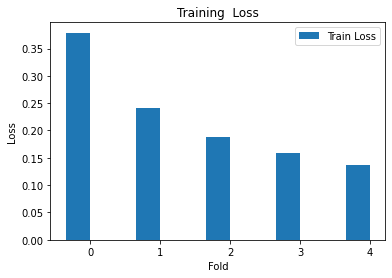

In [ ]:
index = np.arange(5)
x_label = [0,1,2,3,4]
bar_width = 0.35

fig, ax = plt.subplots()
train = ax.bar(index, avg_train_loss, bar_width,
                label="Train Loss")



ax.set_xlabel('Fold')
ax.set_ylabel('Loss')
ax.set_title('Training  Loss')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(x_label)

# ax.set_xticklabels(["ASB", "Violence", "Theft", "Public Order", "Drugs"])
ax.legend()

plt.show()

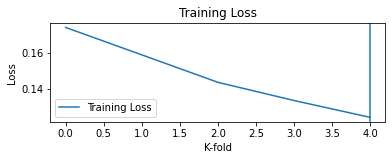

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(avg_train_loss, label='Training Loss')
# ?plt.plot(avg_val_loss, label='Validation Loss')
plt.legend()
plt.title('Training Loss')
plt.axvline(4,  label="Epoch")
# plt.ylabel('merror')
plt.ylabel('Loss')
plt.xlabel('K-fold')
plt.show()

**MENAMPILKAN GAMBAR HASIL PREDIKSI**

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
img, _ = test_dataset[50]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

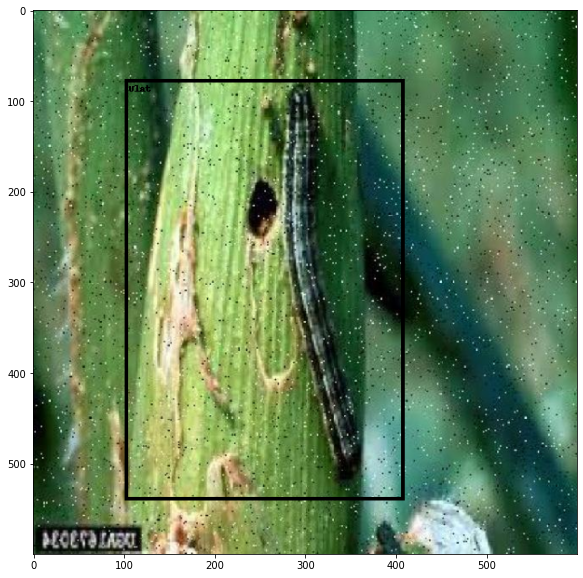

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))